In [22]:
import xarray as xr
import pathlib
import sys
from data_config import (
    get_scratch_dir,
    get_dask_log_dir,
    get_dask_local_dir,
    get_compressed_data_dir,
)

import numpy as np

import ndpyramid
import dask
from distributed import Client
import pop_tools

In [2]:
dask.config.set({'distributed.link.dashboard': '/proxy/{port}/status'})

In [3]:
scratch = get_scratch_dir()
dask_log_directory = get_dask_log_dir()
dask_local_directory = get_dask_local_dir()
out_path_prefix = get_compressed_data_dir()

In [4]:
parent_dir = pathlib.Path.cwd().parent
sys.path.append(str(parent_dir))

In [5]:
client = Client(scheduler_file="/pscratch/sd/a/abanihi/scheduler_file.json")
client

<Client: 'tcp://10.249.1.135:8786' processes=18 threads=18, memory=8.37 TiB>

2025-04-21 16:57:22,005 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [6]:
out_path_prefix

PosixPath('/global/cfs/projectdirs/m4746/Datasets/Ocean-CDR-Atlas-v0/DOR-Efficiency-Map/research-grade-compressed')

In [7]:
polygon_ids = range(0, 690)
padded_polygon_ids = [f"{polygon_id:03d}" for polygon_id in polygon_ids]
injection_months = [1, 4, 7, 10]
padded_injection_months = [
    f"{injection_month:02d}" for injection_month in injection_months
]


def get_glob_pattern(polygon_id, injection_month):
    glob_template = f"{out_path_prefix}/{{}}/{{}}/*.nc"
    path = glob_template.format(polygon_id, injection_month)
    return path


path = get_glob_pattern(padded_polygon_ids[0], padded_injection_months[0])
path

'/global/cfs/projectdirs/m4746/Datasets/Ocean-CDR-Atlas-v0/DOR-Efficiency-Map/research-grade-compressed/000/01/*.nc'

In [8]:
%%time
#with dask.config.set(scheduler="processes"):
ds = xr.open_mfdataset(
    path,
    coords="minimal",
    combine="by_coords",
    data_vars="minimal",
    compat="override",
    decode_timedelta=True,
    decode_times=True,
    parallel=True,
)  # .chunk({'elapsed_time': -1})
ds = dask.optimize(ds)[0]
ds

CPU times: user 6.88 s, sys: 712 ms, total: 7.59 s
Wall time: 21.3 s


<xarray.Dataset> Size: 82GB
Dimensions:                     (polygon_id: 1, injection_date: 1,
                                 elapsed_time: 180, z_t: 60, nlat: 384,
                                 nlon: 320, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60)
Coordinates: (12/63)
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
  * z_w_bot                     (z_w_bot) float32 240B 1e+03 2e+03 ... 5.5e+05
    dz                          (z_t) float32 240B dask.array<chunksize=(60,), meta=np.ndarray>
    ...                          ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
    area_m2                     (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * polygon_id                  (polygon_id) int32 4B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 1kB 0 days ......
Dimensions without coordinates: nlat, nlon
Data variables: (12/46)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    HCO3                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    H2CO3                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ...                          ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    IAGE                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_19...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-11-04 at 21:08:03.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [15]:
ds.data_vars

Data variables:
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    HCO3                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    H2CO3                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320),

In [17]:
dset = xr.open_dataset("/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0361-12.nc")

/pscratch/sd/a/abanihi/ipykernel_360573/1422318843.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dset = xr.open_dataset("/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0361-12.nc")


In [24]:
import xarray as xr
import s3fs




fs = s3fs.S3FileSystem(anon=True)
data_dir = 's3://us-west-2.opendata.source.coop/cworthy/oae-efficiency-atlas/data/'
data_file = 'experiments/009/10/alk-forcing.009-1999-10.pop.h.0347-10.nc'
data_url = data_dir + data_file
ds_data = xr.open_dataset(fs.open(data_url), engine='h5netcdf')
ds_data

ValueError: unrecognized engine 'h5netcdf' must be one of your download engines: ['netcdf4', 'scipy', 'rasterio', 'store', 'zarr']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [23]:
grid = pop_tools.get_grid("POP_gx1v7")
grid

<xarray.Dataset> Size: 11MB
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 480B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 480B 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 480B 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * nreg         (nreg) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 983kB -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG        (nlat, nlon) float64 983kB 320.6 321.7 322.8 ... 319.4 319.8
    ULAT         (nlat, nlon) float64 983kB -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG        (nlat, nlon) float64 983kB 321.1 322.3 323.4 ... 319.6 320.0
    DXT          (nlat, nlon) float64 983kB 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 983kB 5.94e+06 5.94e+06 ... 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 983kB 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    dz           (z_t) float64 480B 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    region_name  (nreg) <U21 1kB 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 104B -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [18]:
dset

<xarray.Dataset> Size: 478MB
Dimensions:                     (time: 1, d2: 2, z_t: 60, z_t_150m: 15,
                                 z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384,
                                 nlon: 320)
Coordinates:
  * time                        (time) object 8B 0362-01-01 00:00:00
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
  * z_w_bot                     (z_w_bot) float32 240B 1e+03 2e+03 ... 5.5e+05
    ULONG                       (nlat, nlon) float64 983kB ...
    ULAT                        (nlat, nlon) float64 983kB ...
    TLONG                       (nlat, nlon) float64 983kB ...
    TLAT                        (nlat, nlon) float64 983kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/97)
    time_bound                  (time, d2) object 16B ...
    dz                          (z_t) float32 240B ...
    dzw                         (z_w) float32 240B ...
    KMT                         (nlat, nlon) float64 983kB ...
    KMU                         (nlat, nlon) float64 983kB ...
    REGION_MASK                 (nlat, nlon) float64 983kB ...
    ...                          ...
    STF_ALK_ALT_CO2             (time, nlat, nlon) float32 492kB ...
    IAGE                        (time, z_t, nlat, nlon) float32 29MB ...
    tend_zint_100m_DIC          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_19...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-11-05 at 03:13:04.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [21]:
for v in dset.variables:
    print(v, dset[v].attrs)

time_bound {'long_name': 'boundaries for time-averaging interval'}
time {'long_name': 'time', 'bounds': 'time_bound'}
z_t {'long_name': 'depth from surface to midpoint of layer', 'units': 'centimeters', 'positive': 'down', 'valid_min': np.float32(500.0), 'valid_max': np.float32(537500.0)}
z_t_150m {'long_name': 'depth from surface to midpoint of layer', 'units': 'centimeters', 'positive': 'down', 'valid_min': np.float32(500.0), 'valid_max': np.float32(14500.0)}
z_w {'long_name': 'depth from surface to top of layer', 'units': 'centimeters', 'positive': 'down', 'valid_min': np.float32(0.0), 'valid_max': np.float32(525000.94)}
z_w_top {'long_name': 'depth from surface to top of layer', 'units': 'centimeters', 'positive': 'down', 'valid_min': np.float32(0.0), 'valid_max': np.float32(525000.94)}
z_w_bot {'long_name': 'depth from surface to bottom of layer', 'units': 'centimeters', 'positive': 'down', 'valid_min': np.float32(1000.0), 'valid_max': np.float32(549999.06)}
dz {'long_name': 'thic

- DIC anomaly/full field (only at surface)
    - delta: `ds.DIC.isel(z_t=0) - ds.DIC_ALT_CO2.isel(z_t=0)`
    - experimental: `ds.DIC.isel(z_t=0)`
- DIC (column integrated)
    - delta: `integrate_column(ds.DIC) - integrate_column(ds.DIC_ALT_CO2)`
    - experimental: `integrate_column(ds.DIC)`
- pCO2 (only at surface)
    - delta: `ds.pCO2SURF - ds.pCO2SURF_ALT_CO2`
    - experimental: `ds.pCO2SURF`
- Flux (only at surface)
    - delta: `ds.FG_CO2 - ds.FG_ALT_CO2`
    - experimental: `ds.FG_CO2`
- Surface pH (only at surface)
    - delta: `ds.PH - ds.PH_ALT_CO2`
    - experimental: `ds.PH`

In [11]:
def integrate_column(var: xr.DataArray, depth_element: xr.DataArray) -> xr.DataArray:
    return (var * depth_element).sum(dim="z_t")

In [13]:
value = (ds.DIC - ds.DIC_ALT_CO2) * ds.dz * ds.TAREA
value

<xarray.DataArray (polygon_id: 1, injection_date: 1, elapsed_time: 180,
                   z_t: 60, nlat: 384, nlon: 320)> Size: 11GB
dask.array<mul, shape=(1, 1, 180, 60, 384, 320), dtype=float64, chunksize=(1, 1, 1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates: (12/58)
  * z_t                     (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
    dz                      (z_t) float32 240B dask.array<chunksize=(60,), meta=np.ndarray>
    ULONG                   (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_t              float64 8B 8.61e+04
    nsurface_u              float64 8B 8.297e+04
    area_m2                 (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * polygon_id              (polygon_id) int32 4B 0
  * injection_date          (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time            (elapsed_time) timedelta64[ns] 1kB 0 days ... 544...
Dimensions without coordinates: nlat, nlon

In [14]:
value.isel(z_t=0)* ds.TAREA * ds.SS

<xarray.DataArray (polygon_id: 1, injection_date: 1, elapsed_time: 180,
                   nlat: 384, nlon: 320)> Size: 177MB
dask.array<getitem, shape=(1, 1, 180, 384, 320), dtype=float64, chunksize=(1, 1, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates: (12/58)
    z_t                     float32 4B 500.0
    dz                      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ULONG                   (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_t              float64 8B 8.61e+04
    nsurface_u              float64 8B 8.297e+04
    area_m2                 (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * polygon_id              (polygon_id) int32 4B 0
  * injection_date          (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time            (elapsed_time) timedelta64[ns] 1kB 0 days ... 544...
Dimensions without coordinates: nlat, nlon

In [12]:
def reduction(ds):
    with xr.set_options(keep_attrs=True):
        dic_surf = ds.DIC.isel(z_t=0)
        ds.ALK.isel(z_t=0)
        dic_delta_surf = ds.DIC.isel(z_t=0) - ds.DIC_ALT_CO2.isel(z_t=0)
        ds.ALK.isel(z_t=0) - ds.ALK_ALT_CO2.isel(z_t=0)

        pH_delta_surf = ds.PH - ds.PH_ALT_CO2
        pco2_delta_surf = ds.pCO2SURF - ds.pCO2SURF_ALT_CO2

        fg_co2_delta_surf = ds.FG_CO2 - ds.FG_ALT_CO2

        dic_column_integrated = integrate_column(ds.DIC, ds["dz"] * 1e-3)
        dic_delta_column_integrated = dic_column_integrated - integrate_column(
            ds.DIC_ALT_CO2, ds["dz"] * 1e-3
        )

    dso = (
        xr.Dataset(
            dict(
                FG_CO2_SURF=ds.FG_CO2,
                FG_CO2_DELTA_SURF=fg_co2_delta_surf,
                DIC_SURF=dic_surf,
                DIC_DELTA_SURF=dic_delta_surf,
                DIC_COLUMN_INTEGRATED=dic_column_integrated,
                DIC_DELTA_COLUMN_INTEGRATED=dic_delta_column_integrated,
                PH_SURF=ds.PH,
                PH_DELTA_SURF=pH_delta_surf,
                pCO2_DELTA_SURF=pco2_delta_surf,
                pCO2_SURF=ds.pCO2SURF,
            )
        )
    ).drop_vars(["TLONG", "TLAT"])
    dso.attrs["case"] = ds.title
    return dso


def concatenate_into_bands(ds: xr.Dataset) -> xr.Dataset:
    bands_ds = xr.Dataset(coords=ds.coords)

    bands_ds["DIC"] = xr.concat(
        [ds["DIC_DELTA_SURF"], ds["DIC_SURF"]],
        dim=xr.DataArray(name="band", data=["delta", "experimental"], dims="band"),
    )
    bands_ds["DIC_INTEGRATED"] = xr.concat(
        [ds["DIC_DELTA_COLUMN_INTEGRATED"], ds["DIC_COLUMN_INTEGRATED"]],
        dim=xr.DataArray(name="band", data=["delta", "experimental"], dims="band"),
    )
    bands_ds["PH"] = xr.concat(
        [ds["PH_DELTA_SURF"], ds["PH_SURF"]],
        dim=xr.DataArray(name="band", data=["delta", "experimental"], dims="band"),
    )
    bands_ds["FG"] = xr.concat(
        [ds["FG_CO2_DELTA_SURF"], ds["FG_CO2_SURF"]],
        dim=xr.DataArray(name="band", data=["delta", "experimental"], dims="band"),
    )
    bands_ds["pCO2SURF"] = xr.concat(
        [ds["pCO2_DELTA_SURF"], ds["pCO2_SURF"]],
        dim=xr.DataArray(name="band", data=["delta", "experimental"], dims="band"),
    )

    # notice we chunk along the band dimension
    return bands_ds.isel(
        z_t=0, missing_dims="warn"
    )  # .chunk(band=1, nlat=384, nlon=320)


def reshape_into_month_year(ds: xr.Dataset) -> xr.Dataset:
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        reshaped = (
            ds.assign_coords(
                month=xr.DataArray(
                    data=np.concatenate([np.arange(1, 13)] * 15), dims="elapsed_time"
                ).astype("int32"),
                year=xr.DataArray(
                    data=np.repeat(np.arange(1, 16), 12), dims="elapsed_time"
                ).astype("int32"),
            )
            .swap_dims(
                elapsed_time="month",
            )
            .set_index(
                monthyear=("month", "year"),
            )
            .unstack(
                "monthyear",
            )
        )

    to_drop_coords = set(reshaped.coords).difference(
        set(
            [
                "band",
                "elapsed_time",
                "injection_date",
                "month",
                "polygon_id",
                "year",
                "ULONG",
                "ULAT",
            ]
        )
    )
    reshaped["injection_date"] = reshaped.injection_date.dt.month.astype("float32")

    return reshaped.drop_vars(to_drop_coords)

In [13]:
def create_pyramid(polygon_id, store_path="s3://carbonplan-dor-efficiency/store2.zarr"):
    for injection_month in padded_injection_months:
        path = get_glob_pattern(polygon_id, injection_month)
        ds = xr.open_mfdataset(
            path,
            coords="minimal",
            combine="by_coords",
            data_vars="minimal",
            compat="override",
            decode_times=True,
            parallel=True,
        )
        ds = dask.optimize(ds)[0]
        bands_ds = (
            ds.pipe(reduction)
            .pipe(concatenate_into_bands)
            .pipe(reshape_into_month_year)
        )
        other_chunks = dict(
            month=1, year=-1, band=1, polygon_id=1, injection_date=1, x=128, y=128
        )
        pyramid = ndpyramid.pyramid_regrid(
            bands_ds.chunk(nlat=-1, nlon=-1),
            levels=2,
            projection="web-mercator",
            parallel_weights=False,
            other_chunks=other_chunks,
        )

        pyramid = dask.optimize(pyramid)[0]
        pyramid.to_zarr(store_path, region="auto", mode="r+")
        print(
            f"finished processing polygon_id={polygon_id}, injection_month={injection_month}"
        )

In [14]:
bands_ds = ds.pipe(reduction).pipe(concatenate_into_bands).pipe(reshape_into_month_year)
bands_ds

/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)


<xarray.Dataset> Size: 887MB
Dimensions:         (month: 12, year: 15, polygon_id: 1, injection_date: 1,
                     band: 2, nlat: 384, nlon: 320)
Coordinates:
  * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * polygon_id      (polygon_id) int32 4B 0
  * injection_date  (injection_date) float32 4B 1.0
  * band            (band) <U12 96B 'delta' 'experimental'
    ULONG           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    elapsed_time    (month, year) timedelta64[ns] 1kB 0 days ... 5444 days
Dimensions without coordinates: nlat, nlon
Data variables:
    DIC             (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB dask.array<chunksize=(1, 1, 1, 384, 320, 1, 1), meta=np.ndarray>
    DIC_INTEGRATED  (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB dask.array<chunksize=(1, 1, 1, 384, 320, 1, 1), meta=np.ndarray>
    PH              (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB dask.array<chunksize=(1, 1, 1, 384, 320, 1, 1), meta=np.ndarray>
    FG              (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB dask.array<chunksize=(1, 1, 1, 384, 320, 1, 1), meta=np.ndarray>
    pCO2SURF        (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB dask.array<chunksize=(1, 1, 1, 384, 320, 1, 1), meta=np.ndarray>

In [16]:
weights_pyramid = ndpyramid.regrid.generate_weights_pyramid(bands_ds, levels=2)
weights_pyramid

<xarray.DataTree>
Group: /
│   Attributes:
│       levels:         2
│       regrid_method:  bilinear
├── Group: /0
│       Dimensions:  (n_s: 48772)
│       Dimensions without coordinates: n_s
│       Data variables:
│           S        (n_s) float64 390kB 0.3384 0.4915 0.06935 ... 0.06423 0.02826
│           col      (n_s) int32 195kB 115054 115055 115374 115375 ... 194 195 514 515
│           row      (n_s) int32 195kB 1 1 1 1 2 2 ... 14335 14336 14336 14336 14336
│       Attributes:
│           n_in:     122880
│           n_out:    16384
└── Group: /1
        Dimensions:  (n_s: 194184)
        Dimensions without coordinates: n_s
        Data variables:
            S        (n_s) float64 2MB 0.6083 0.1826 0.1608 ... 0.6079 0.02408 0.3227
            col      (n_s) int32 777kB 115054 115055 115374 115375 ... 194 195 514 515
            row      (n_s) int32 777kB 1 1 1 1 2 2 ... 57087 57088 57088 57088 57088
        Attributes:
            n_in:     122880
            n_out:    65536

In [26]:
%%time
ndpyramid.pyramid_regrid(bands_ds, levels=2, parallel_weights=False)

CPU times: user 3.83 s, sys: 147 ms, total: 3.98 s
Wall time: 3.98 s


<xarray.DataTree>
Group: /
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0', 'level': 0, 'crs': 'EPSG:3857'...
│       title:        multiscale data pyramid
│       version:      0.4.0
├── Group: /0
│       Dimensions:         (band: 2, polygon_id: 1, injection_date: 1, month: 12,
│                            year: 15, y: 128, x: 128)
│       Coordinates:
│         * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
│         * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│         * polygon_id      (polygon_id) int32 4B 0
│         * injection_date  (injection_date) float32 4B 1.0
│         * band            (band) <U12 96B 'delta' 'experimental'
│           elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│       Data variables:
│           DIC             (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
│           DIC_INTEGRATED  (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
│           PH              (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
│           FG              (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
│           pCO2SURF        (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
│       Attributes:
│           regrid_method:  bilinear
│           multiscales:    [{'datasets': [{'path': '.', 'level': 0, 'crs': 'EPSG:385...
└── Group: /1
        Dimensions:         (band: 2, polygon_id: 1, injection_date: 1, month: 12,
                             year: 15, y: 256, x: 256)
        Coordinates:
          * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
          * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
          * polygon_id      (polygon_id) int32 4B 0
          * injection_date  (injection_date) float32 4B 1.0
          * band            (band) <U12 96B 'delta' 'experimental'
            elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
        Data variables:
            DIC             (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
            DIC_INTEGRATED  (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
            PH              (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
            FG              (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
            pCO2SURF        (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(1, 1, 1, 1, 1, 128, 128), meta=np.ndarray>
        Attributes:
            regrid_method:  bilinear
            multiscales:    [{'datasets': [{'path': '.', 'level': 1, 'crs': 'EPSG:385...

In [31]:
%%time
dt = create_pyramid(padded_polygon_ids[0])

/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=01


/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.44 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=04


/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=07


/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=10
CPU times: user 1min 3s, sys: 1.84 s, total: 1min 5s
Wall time: 20min 44s


In [17]:
# bands_ds = ds.pipe(reduction).pipe(concatenate_into_bands).pipe(reshape_into_month_year)
# bands_ds

In [18]:
# %%time

# other_chunks = dict(month=1, year=-1, band=1, polygon_id=1, injection_date=1, x=128, y=128)
# pyramid = ndpyramid.pyramid_regrid(
#     bands_ds.chunk(nlat=-1, nlon=-1),
#     levels=2,
#     projection="web-mercator",
#     parallel_weights=False,
#     other_chunks=other_chunks,
# )

# pyramid = dask.optimize(pyramid)[0]
# pyramid

In [19]:
# pyramid["0"]["FG"].sel(band="experimental").isel(
#     month=0, year=0, polygon_id=0, injection_date=0
# ).plot(robust=True)

In [20]:
# %%time
# path = 's3://carbonplan-dor-efficiency/store2.zarr'
# pyramid.to_zarr(path, region='auto', mode='r+')

In [3]:
path = "s3://carbonplan-dor-efficiency/store2.zarr"
path2 = "s3://carbonplan-oae-efficiency/v2/store2.zarr/"
# path = '/pscratch/sd/a/abanihi/store2.zarr'
dt = xr.open_datatree(path, engine="zarr", chunks={})
dt

<xarray.DataTree>
Group: /
│   Attributes:
│       multiscales:  [{'datasets': [{'crs': 'EPSG:3857', 'level': 0, 'path': '0'...
│       title:        multiscale data pyramid
│       version:      0.4.0
├── Group: /0
│       Dimensions:         (polygon_id: 690, band: 2, injection_date: 4, month: 12,
│                            year: 15, y: 128, x: 128)
│       Coordinates:
│         * band            (band) <U12 96B 'delta' 'experimental'
│           dz              float32 4B ...
│           elapsed_time    (month, year) float32 720B dask.array<chunksize=(1, 15), meta=np.ndarray>
│         * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
│         * month           (month) float64 96B 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
│         * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│         * year            (year) float64 120B 1.0 2.0 3.0 4.0 ... 12.0 13.0 14.0 15.0
│       Data variables:
│           DIC             (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           DIC_INTEGRATED  (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           PH              (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           FG              (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           pCO2SURF        (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│       Attributes:
│           multiscales:    [{'datasets': [{'crs': 'EPSG:3857', 'level': 0, 'path': '...
│           regrid_method:  bilinear
└── Group: /1
        Dimensions:         (polygon_id: 690, band: 2, injection_date: 4, month: 12,
                             year: 15, y: 256, x: 256)
        Coordinates:
            dz              float32 4B ...
          * band            (band) <U12 96B 'delta' 'experimental'
            elapsed_time    (month, year) float32 720B dask.array<chunksize=(1, 15), meta=np.ndarray>
          * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
          * month           (month) float64 96B 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
          * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
          * year            (year) float64 120B 1.0 2.0 3.0 4.0 ... 12.0 13.0 14.0 15.0
        Data variables:
            DIC             (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            DIC_INTEGRATED  (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            PH              (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            pCO2SURF        (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            FG              (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
        Attributes:
            multiscales:    [{'datasets': [{'crs': 'EPSG:3857', 'level': 1, 'path': '...
            regrid_method:  bilinear

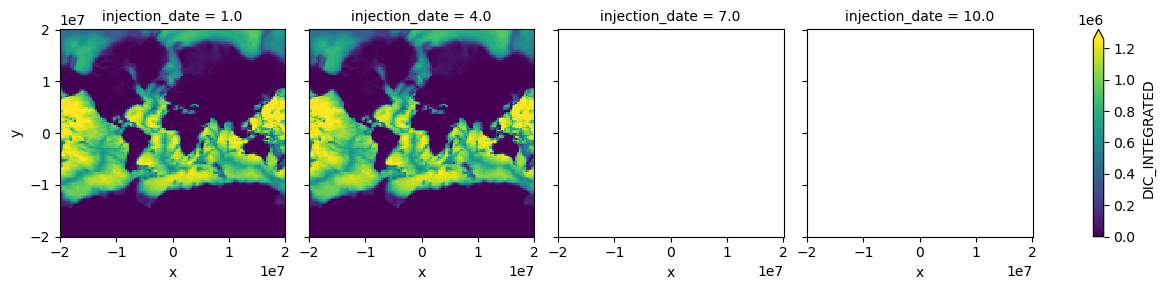

In [18]:
dt["0"]["DIC_INTEGRATED"].sel(band="experimental").isel(
    month=0, year=0, polygon_id=1
).plot(col="injection_date", robust=True)

In [6]:
dt["0"]["DIC_INTEGRATED"].encoding

{'chunks': (1, 1, 1, 1, 15, 128, 128),
 'preferred_chunks': {'polygon_id': 1,
  'band': 1,
  'injection_date': 1,
  'month': 1,
  'year': 15,
  'y': 128,
  'x': 128},
 'compressors': (Zlib(level=1),),
 'filters': (),
 'shards': None,
 '_FillValue': np.float32(9.96921e+36),
 'dtype': dtype('float32'),
 'coordinates': 'elapsed_time'}